# IMPORT

In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Reshape, LSTM, Input, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

import seaborn as sns
from collections import Counter
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
# Various types of layers for building neural networks
from tensorflow.keras.applications import DenseNet121, EfficientNetB4, Xception, VGG16, VGG19   # Pre-trained models for transfer learning

In [44]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
INPUT_SHAPE = IMG_SIZE + (3,)
NUM_CLASSES = 3

In [46]:
# Fungsi Deteksi Objek Menggunakan YOLOv5
def detect_objects_yolo(image_path, model_path='yolov5s'):
    model = torch.hub.load('ultralytics/yolov5', model_path)
    results = model(image_path)
    detections = results.xyxy[0] 
    detections = detections.cpu().numpy()
    return detections, results

## Fungsi untuk memproses gambar dengan deteksi objek

In [48]:
def preprocess_with_detection_and_processing(image_path, target_size=(64, 64)):
    # Deteksi objek
    detections, _ = detect_objects_yolo(image_path)
    
    img = cv2.imread(image_path)
    
    if len(detections) > 0:
        # Pilih deteksi dengan confidence tertinggi
        x_min, y_min, x_max, y_max, _, _ = detections[0]
        img = img[int(y_min):int(y_max), int(x_min):int(x_max)]
    
    # Resize ke ukuran target
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    
    # Image Processing: Edge Detection dan Sharpening
    kernel_edge = np.array([[-1, -1, -1],
                            [-1,  8, -1],
                            [-1, -1, -1]])
    edges = cv2.filter2D(img, -1, kernel_edge)
    
    kernel_sharpen = np.array([[0, -1, 0],
                               [-1,  5, -1],
                               [0, -1, 0]])
    processed_img = cv2.filter2D(edges, -1, kernel_sharpen)
    
    return processed_img

### Augmentasi Data dan Normalisasi data

In [50]:
# Custom ImageDataGenerator dengan Preprocessing
class CustomImageDataGeneratorWithProcessing(ImageDataGenerator):
    def preprocessing_function(self, img_path):
        return preprocess_with_detection_and_processing(img_path, target_size=IMG_SIZE)

In [52]:
# Data Generators
train_datagen = CustomImageDataGeneratorWithProcessing(
    rescale=1.0 / 255.0,
    zoom_range=0.3,
    brightness_range=[0.6, 1.4]
)

validation_datagen = CustomImageDataGeneratorWithProcessing(rescale=1.0 / 255.0)
test_datagen = CustomImageDataGeneratorWithProcessing(rescale=1.0 / 255.0)

In [54]:
# Directories (Adjust paths as needed)
train_dir = 'newdataset/train/'
val_dir = 'newdataset/valid/'
test_dir = 'newdataset/test/'

# Load Data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Update NUM_CLASSES based on data
NUM_CLASSES = train_generator.num_classes
labels = train_generator.class_indices.keys()


Found 401 images belonging to 3 classes.
Found 78 images belonging to 3 classes.
Found 50 images belonging to 3 classes.


In [17]:
labels

dict_keys(['antraknosa', 'blackspot', 'keriting-daun'])

Visualisasi data dengan train:


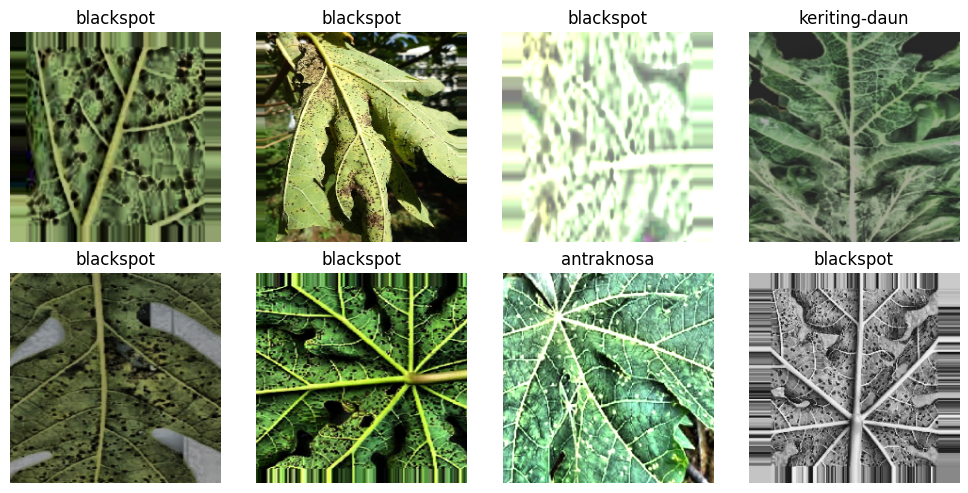

In [19]:
def plot_augmented_images(generator, labels, num_images=8):
    images, labels_batch = next(generator)

    num_images = min(num_images, len(images))  
    labels_decoded = [list(labels)[np.argmax(label)] for label in labels_batch[:num_images]]
    cols = 4  
    rows = (num_images + cols - 1) // cols  
    plt.figure(figsize=(cols * 2.5, rows * 2.5)) 

    for i in range(num_images):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i])
        plt.title(labels_decoded[i])
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

print("Visualisasi data dengan train:")
plot_augmented_images(train_generator, labels)


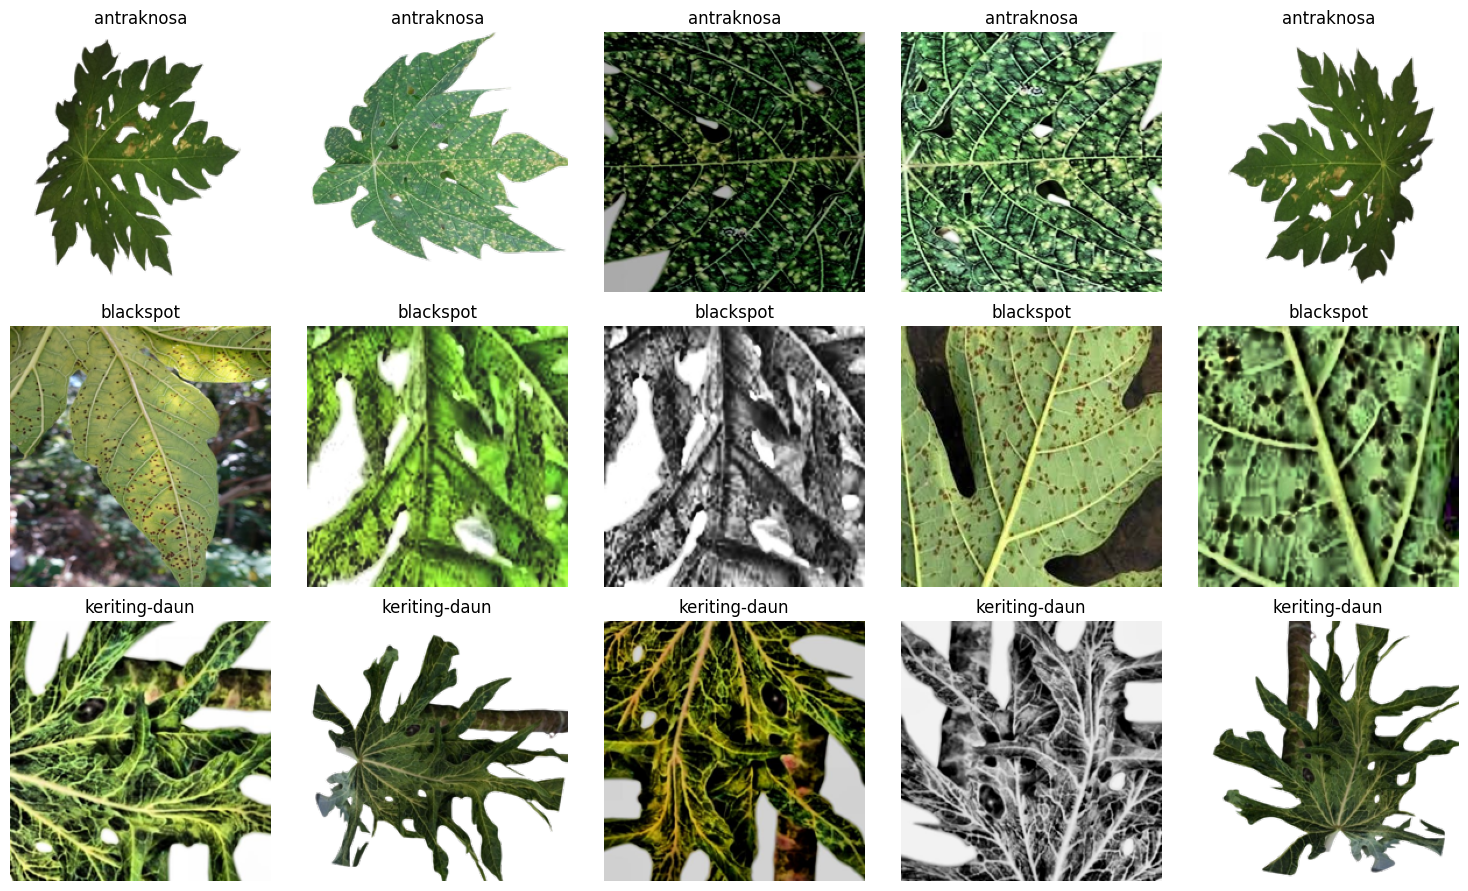

In [21]:
import os
from PIL import Image  
import matplotlib.pyplot as plt

def visualize_samples_per_class(directory, target_size, samples_per_class=5):
    classes = os.listdir(directory)
    plt.figure(figsize=(15, len(classes) * 3))
    
    for i, cls in enumerate(classes):
        class_path = os.path.join(directory, cls)
        images = os.listdir(class_path)[:samples_per_class]
        
        for j, img_file in enumerate(images):
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path).resize(target_size) 
            
            plt.subplot(len(classes), samples_per_class, i * samples_per_class + j + 1)
            plt.imshow(img)
            plt.title(cls)
            plt.axis("off")
    
    plt.tight_layout()
    plt.show()

visualize_samples_per_class(train_dir, target_size=IMG_SIZE, samples_per_class=5)


C:\Users\HP\AppData\Local\Temp\ipykernel_8896\3841989112.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=counts, palette="viridis")


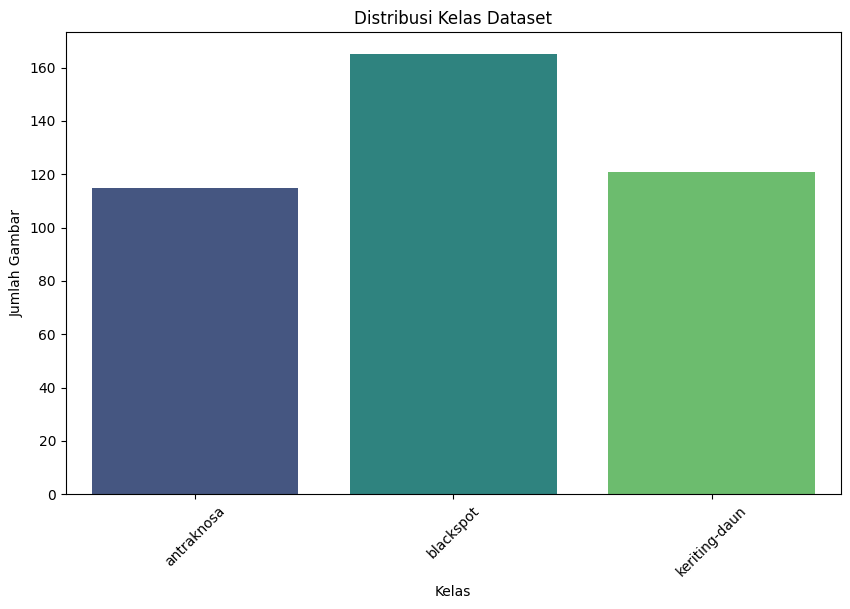

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter 
import numpy as np

def plot_class_distribution(generator):
    """Visualisasi distribusi kelas"""
    class_counts = Counter(generator.classes) 
    class_names = list(generator.class_indices.keys())
    counts = [class_counts[i] for i in range(len(class_names))]  
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_names, y=counts, palette="viridis")
    plt.title("Distribusi Kelas Dataset")
    plt.ylabel("Jumlah Gambar")
    plt.xlabel("Kelas")
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train_generator)


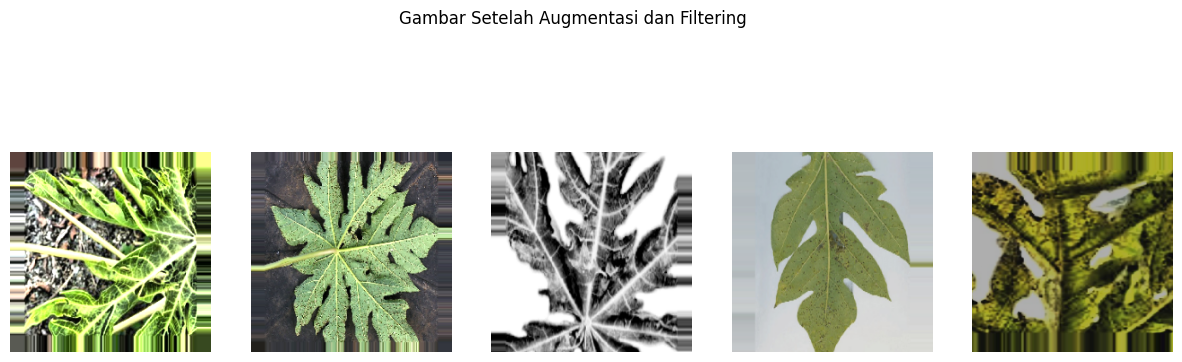

In [25]:
# Fungsi visualisasi
def visualize_augmented_images(generator, num_images=5):
    images, labels = next(generator)
    plt.figure(figsize=(15, 5))
    
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    
    plt.suptitle("Gambar Setelah Augmentasi dan Filtering")
    plt.show()

# Visualisasikan gambar
visualize_augmented_images(train_generator, num_images=5)

In [27]:
# Define TF Data Generator
def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None, input_shape[0], input_shape[1], input_shape[2]], [None, num_class])
    )
    return tf_generator

train_data = tf_data_generator(train_generator, INPUT_SHAPE)
val_data = tf_data_generator(validation_generator, INPUT_SHAPE)
test_data = tf_data_generator(test_generator, INPUT_SHAPE)


Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
import tensorflow as tf

# Misalkan INPUT_SHAPE adalah (height, width, channels)
# Misalkan NUM_CLASSES adalah jumlah kelas output

model = Sequential([
    # Layer Konvolusi Pertama
    Conv2D(32, kernel_size=(3, 3), activation='tanh', input_shape=INPUT_SHAPE),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    # Layer Konvolusi Kedua
    Conv2D(64, kernel_size=(3, 3), activation='tanh'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    # Layer Konvolusi Ketiga
    Conv2D(128, kernel_size=(3, 3), activation='tanh'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    # Layer Konvolusi Keempat
    Conv2D(256, kernel_size=(3, 3), activation='tanh'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    # Mengganti Flatten dengan GlobalAveragePooling2D
    layers.GlobalAveragePooling2D(),
    
     # Menambahkan beberapa layer Dense
    Dense(512, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.2),
    BatchNormalization(),
    Dense(256, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.2),
    BatchNormalization(),
    Dense(128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.2),
    BatchNormalization(),

    
    Dense(NUM_CLASSES, activation='softmax')
])

# Kompilasi model dengan optimizer Adam
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, Model

# Load DenseNet121 pretrained model
conv_base = DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Adding custom layers
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation="relu")(x)

predictions = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = Model(inputs=conv_base.input, outputs=predictions)

# Model Summary
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 230, 230, 3)       │               0 │ input_layer_1[0][0]        │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 56, 56, 64)        │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 56, 56, 64)        │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 128)       │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 128)       │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 128)       │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 32)        │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 56, 56, 96)        │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 7,563,843 (28.85 MB)

 Trainable params: 7,480,195 (28.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

### TUNING HYPERPARAMETER

In [37]:
import tensorflow as tf
from keras.callbacks import Callback, EarlyStopping
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau

In [39]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.001,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

In [41]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [43]:
# Kompilasi model
model.compile(
    optimizer=tf.optimizers.SGD(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [45]:
# Training model
history = model.fit(
    train_generator,
    epochs= 25,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/25


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 276s 11s/step - accuracy: 0.5027 - loss: 1.1307 - val_accuracy: 0.6154 - val_loss: 0.7720 - learning_rate: 0.0100
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 135s 10s/step - accuracy: 0.8847 - loss: 0.3780 - val_accuracy: 0.8205 - val_loss: 0.3818 - learning_rate: 0.0100
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 133s 10s/step - accuracy: 0.9338 - loss: 0.2182 - val_accuracy: 0.8974 - val_loss: 0.2524 - learning_rate: 0.0100
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 137s 10s/step - accuracy: 0.9477 - loss: 0.1575 - val_accuracy: 0.9487 - val_loss: 0.1924 - learning_rate: 0.0100
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 137s 10s/step - accuracy: 0.9674 - loss: 0.1269 - val_accuracy: 0.9744 - val_loss: 0.0944 - learning_rate: 0.0100
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 133s 10s/step - accuracy: 0.9708 - loss: 0.0987 - val_accuracy: 0.9872 - val_loss: 0.0738 - learning_rate: 0.0100
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 133s 10s/step - accuracy: 0.9668 - loss: 0.1172 - val_accurac

### SIMPAN MODEL

In [47]:
model.save("pepaya_disease_model.keras")

### LOAD MODEL

In [35]:
from tensorflow.keras.models import load_model

model = load_model("pepaya_disease_model.keras")


###  Evaluasi model pada validation data

In [55]:
val_loss, val_accuracy = model.evaluate(validation_generator)

# Menampilkan hasil evaluasi
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9897 - loss: 0.0316
Validation Loss: 0.0359
Validation Accuracy: 0.9872


### TEST

In [57]:
test_loss, test_accuracy = model.evaluate(test_generator)

# Menampilkan hasil evaluasi
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 967ms/step - accuracy: 0.9287 - loss: 0.1545
Test Loss: 0.1307
Test Accuracy: 0.9400


### CONFUSION MATRIKS

In [83]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [75]:

predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Prediksi kelas
true_classes = test_generator.classes               # Label asli
class_labels = list(test_generator.class_indices.keys())  # Nama kelas


2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step


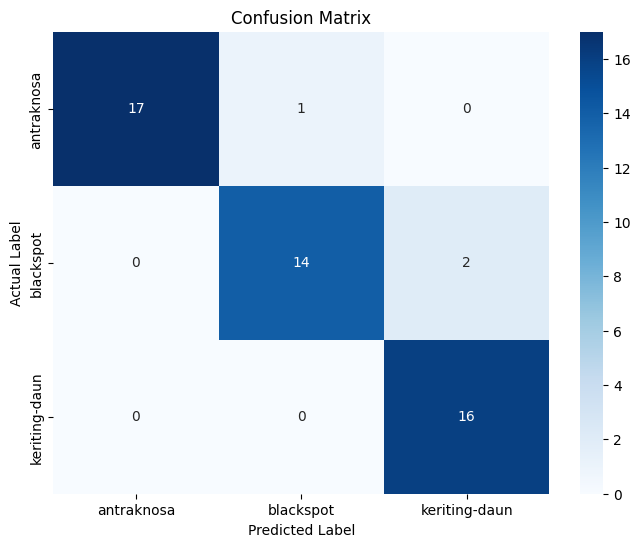

In [76]:

cm = confusion_matrix(true_classes, predicted_classes)
# 5. Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

### MODEL EVALUATION

In [85]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# 5. Menampilkan Laporan
print("Classification Report:\n")
print(report)

Classification Report:

               precision    recall  f1-score   support

   antraknosa       1.00      0.94      0.97        18
    blackspot       0.93      0.88      0.90        16
keriting-daun       0.89      1.00      0.94        16

     accuracy                           0.94        50
    macro avg       0.94      0.94      0.94        50
 weighted avg       0.94      0.94      0.94        50



In [59]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, confusion_matrix

# Ambil hasil prediksi dan kelas asli
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Prediksi kelas
true_classes = test_generator.classes  # Label asli

# Menghitung metrik
accuracy = accuracy_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes, average='macro')  # Gunakan 'micro' atau 'weighted' jika diperlukan
f1 = f1_score(true_classes, predicted_classes, average='macro')
precision = precision_score(true_classes, predicted_classes, average='macro')
cm = confusion_matrix(true_classes, predicted_classes)

# Menghitung specificity
tn = cm.diagonal()  # True Negative (TN) per kelas
fp = cm.sum(axis=0) - tn  # False Positive (FP) per kelas
specificity = tn / (tn + fp)

# Print hasil
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
# Print Specificity untuk setiap kelas
print(f"Specificity: {specificity}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
Accuracy: 0.9800
Recall: 0.9792
F1 Score: 0.9797
Precision: 0.9815
Specificity: [1.         1.         0.94444444]


In [87]:
errors = np.where(predicted_classes != true_classes)[0]
print("Sampel salah klasifikasi:", errors)

Sampel salah klasifikasi: [16 18 28]
